In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


In [2]:
df = pd.read_csv('nba_engineered_game_df.csv')
df = df.sort_values(by=['date']).reset_index(drop=True)
pd.set_option('display.max_columns', None)
df.head(6)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_TS%_advanced_totals,Team_B_+/-_basic_max,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_totals_last5,Team_A_FG_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_TS%_advanced_totals_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_totals_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_totals_last5,Team_B_eFG%_advanced_totals_last5,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,Team_A_H2H_WinPct_before_next_matchup,Team_B_H2H_WinPct_before_next_matchup
0,12,13,LAC_vs_LAL,2009-10-27,14.0,15.1,94.4,0.489,14.0,102.0,94.4,0,0,1.0,2010-01-06,0.6,10.6,109.88,0.5052,10.6,20.70,108.72,24.0,0.5796,0.5494,0.8,17.0,115.6,108.58,0.4922,26.84,116.30,53.76,0.5806,0.5368,1494.392503,1505.607497,1463.954139,1624.320773,-160.366633,-11.214994,0.0,1.0,0.454545,0.823529,0.0,1.0
1,6,29,DAL_vs_WAS,2009-10-27,7.0,21.5,101.1,0.500,16.0,112.0,101.1,0,1,1.0,2010-01-20,0.4,5.4,114.32,0.4608,10.4,21.44,106.28,29.4,0.5448,0.4978,0.4,8.6,119.0,110.58,0.4482,21.74,108.66,48.60,0.5268,0.4806,1484.678284,1515.321716,1568.879986,1431.616053,137.263933,-30.643432,0.0,1.0,0.658537,0.350000,0.0,1.0
2,10,24,HOU_vs_POR,2009-10-27,8.0,14.6,90.1,0.464,15.0,94.0,90.1,0,0,1.0,2009-10-31,0.5,9.0,104.50,0.4175,9.0,16.45,100.35,22.0,0.5170,0.4680,0.5,12.0,107.0,102.00,0.3875,21.55,104.90,57.85,0.5145,0.4355,1493.511952,1506.488048,1499.243590,1498.709008,0.534582,-12.976096,0.0,1.0,0.500000,0.500000,0.0,1.0
3,1,5,BOS_vs_CLE,2009-10-27,11.0,18.0,106.0,0.569,3.0,115.0,106.6,1,0,0.0,2010-02-25,0.8,12.6,101.02,0.4870,8.4,18.72,105.28,22.2,0.5476,0.5212,0.4,12.6,122.0,114.40,0.4730,28.24,113.20,49.64,0.5486,0.5200,1510.759671,1489.240329,1584.606665,1682.261231,-97.654566,21.519342,1.0,0.0,0.654545,0.758621,1.0,0.0
4,18,26,NOP_vs_SAS,2009-10-28,1.0,19.6,105.1,0.547,17.0,110.0,105.1,0,0,0.0,2010-01-18,0.6,17.2,108.34,0.4718,8.8,23.30,111.54,23.2,0.5526,0.5204,0.6,9.4,109.8,101.56,0.4568,20.52,103.94,51.36,0.5138,0.4918,1490.236781,1509.763219,1507.165544,1577.891741,-70.726196,-19.526439,0.0,1.0,0.538462,0.615385,0.0,1.0
5,0,11,ATL_vs_IND,2009-10-28,23.0,24.1,118.4,0.601,12.0,123.0,119.0,1,1,1.0,2009-12-26,0.6,17.0,104.46,0.4628,10.0,20.96,110.52,26.4,0.5428,0.5060,0.2,9.6,113.0,103.98,0.4338,19.30,99.10,49.44,0.5220,0.4786,1507.339585,1492.660415,1592.869059,1417.879696,174.989363,14.679169,1.0,0.0,0.714286,0.333333,1.0,0.0


In [3]:
df = df.drop(columns=['date', 'next_matchup_date', 'matchup_id'])
train_size = int(0.8 * len(df))  
val_size = len(df) - train_size 
#int(0.15 * len(df))   
#test_size = len(df) - train_size - val_size  

y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])
x_train = df.iloc[:train_size]
x_val = df.iloc[train_size:]
#x_test = df.iloc[train_size+val_size:]
y_train = y.iloc[:train_size]
y_train = y_train.to_numpy().reshape(-1,1)
y_val = y.iloc[train_size:]
y_val = y_val.to_numpy().reshape(-1,1)
#y_test = y.iloc[train_size+val_size:]
#y_test = y_test.to_numpy().reshape(-1,1)
x_train.shape

(14980, 43)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B'])
normalize_cols = [col for col in all_columns if col not in exclude_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
#x_test = x_test.to_numpy()

x_train[:, normalize_indices] = (x_train[:, normalize_indices] - mean) / std
x_val[:, normalize_indices] = (x_val[:, normalize_indices] - mean) / std
#x_test[:, normalize_indices] = (x_test[:, normalize_indices] - mean) / std

In [6]:
num_features = x_train.shape[1]
w = np.random.normal(0, 0.01, size=(num_features, 1))
b = 0
#z = x_train @ w + b
#y_pred = sigmoid(z)

In [7]:
def compute_cost(x, y, w, b):
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    loss = - (1/m) * (y.T @ np.log(y_pred) + (1 - y).T @ np.log(1 - y_pred))
    return loss.item()

In [8]:
def compute_gradients(x, y, w, b): 
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    dj_dw = (1/m) * x.T @ (y_pred - y) 
    dj_db = (1/m) * np.sum(y_pred - y)
    return dj_dw, dj_db

In [9]:
learning_rate = 0.01
num_epochs = 100
train_cost_history = []
val_cost_history = []

for epoch in range(num_epochs):
    dj_dw, dj_db = compute_gradients(x_train, y_train, w, b)
    
    #print(f"Epoch {epoch+1}")
    #print(f"  Mean dj_dw: {np.mean(dj_dw):.6f}, dj_db: {dj_db:.6f}")
    #print(f"  Mean weight before update: {np.mean(w):.6f}")

    w = w - (learning_rate * dj_dw)
    b = b - (learning_rate * dj_db)
    
    #print(f"  Mean weight after update: {np.mean(w):.6f}")
    #print(f"  Training Cost: {train_cost:.6f}, Validation Cost: {val_cost:.6f}")
    
    train_cost = compute_cost(x_train, y_train, w, b)
    train_cost_history.append(train_cost) 
    val_cost = compute_cost(x_val, y_val, w, b)
    val_cost_history.append(val_cost) 
    print(f"Epoch {epoch+1}/{num_epochs}, Training Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")


Epoch 1/100, Training Cost: 0.6901, Validation Cost: 0.6884
Epoch 2/100, Training Cost: 0.6871, Validation Cost: 0.6884
Epoch 3/100, Training Cost: 0.6848, Validation Cost: 0.6855
Epoch 4/100, Training Cost: 0.6826, Validation Cost: 0.6840
Epoch 5/100, Training Cost: 0.6806, Validation Cost: 0.6821
Epoch 6/100, Training Cost: 0.6787, Validation Cost: 0.6805
Epoch 7/100, Training Cost: 0.6768, Validation Cost: 0.6789
Epoch 8/100, Training Cost: 0.6751, Validation Cost: 0.6774
Epoch 9/100, Training Cost: 0.6734, Validation Cost: 0.6759
Epoch 10/100, Training Cost: 0.6718, Validation Cost: 0.6746
Epoch 11/100, Training Cost: 0.6702, Validation Cost: 0.6732
Epoch 12/100, Training Cost: 0.6688, Validation Cost: 0.6720
Epoch 13/100, Training Cost: 0.6674, Validation Cost: 0.6708
Epoch 14/100, Training Cost: 0.6660, Validation Cost: 0.6696
Epoch 15/100, Training Cost: 0.6647, Validation Cost: 0.6686
Epoch 16/100, Training Cost: 0.6635, Validation Cost: 0.6675
Epoch 17/100, Training Cost: 0.66

In [10]:
z_val = x_val @ w + b
y_val_probs = sigmoid(z_val)
y_val_pred = (y_val_probs >= 0.5).astype(int)
accuracy = np.mean(y_val_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.3f}%")

Validation Accuracy: 62.493%


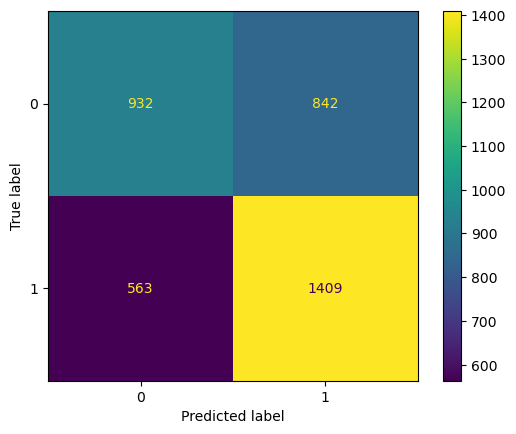

In [11]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()

In [12]:
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
probs = sigmoid(x_val @ w + b)
auc = roc_auc_score(y_val, probs)
print("AUC:", auc)

TPR: 0.7145
FPR: 0.475
TNR: 0.525
FNR: 0.285
AUC: 0.6730169383774192


In [13]:
'''
REDO 0.05!! (ADDED HEAD TO HEAD WIN PCT)
DROPPING FEATURES WITH DCOR < 0.05 
Validation Accuracy: 62.413%
TPR: 0.6795
FPR: 0.437
TNR: 0.563
FNR: 0.320
AUC: 0.6700498066504913

DROPPING FEATURES WITH DCOR < 0.08
Validation Accuracy: 62.547%
TPR: 0.7039
FPR: 0.462
TNR: 0.538
FNR: 0.296
AUC: 0.673579778682845

Validation Accuracy: 62.493%
TPR: 0.7145
FPR: 0.475
TNR: 0.525
FNR: 0.285
AUC: 0.6730169383774192
'''

'\nREDO 0.05!! (ADDED HEAD TO HEAD WIN PCT)\nDROPPING FEATURES WITH DCOR < 0.05 \nValidation Accuracy: 62.413%\nTPR: 0.6795\nFPR: 0.437\nTNR: 0.563\nFNR: 0.320\nAUC: 0.6700498066504913\n\nDROPPING FEATURES WITH DCOR < 0.08\nValidation Accuracy: 62.547%\nTPR: 0.7039\nFPR: 0.462\nTNR: 0.538\nFNR: 0.296\nAUC: 0.673579778682845\n\nValidation Accuracy: 62.013%\nTPR: 0.7018\nFPR: 0.471\nTNR: 0.529\nFNR: 0.298\nAUC: 0.6704780112099267\n'